# PyTorch Custom Data Creation (from Food101)

Making a dataset to use with notebook 04 (creating a PyTorch dataset).

Going to leverage the fact that PyTorch now incorporates Food101.

I'll get the images for 3 classes: Pizza, Steak, Sushi and store them in their respective files.

> **Note:** To use the Food101 dataset with PyTorch requires PyTorch 1.11+ and `torchvision` 0.12.0+.

Want:

```
pizza_steak_sushi/
    train/
        pizza/
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image04.jpeg
            image05.jpeg
            ...
        sushi/
            image07.jpeg
            ...
    test/
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image104.jpeg
            image105.jpeg
            ...
        sushi/
            image107.jpeg
            ...
```

In [1]:
import torch
import torchvision

# Note: Required to have PyTorch > 1.11.0 & torchvision > 0.12.0 for Food101 dataset
assert int(torch.__version__.split(".")[1]) >= 11
assert int(torchvision.__version__.split(".")[1]) >= 11

import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Setup data directory
import pathlib
data_dir = pathlib.Path("../data")

## Download data

Get the Food101 dataset from PyTorch.
* Food101 in `torchvision.datasets` - https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html
* Original Food101 dataset - https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/ 

> **Note:** Downloading the dataset from PyTorch may take ~10-15 minutes depending on your internet speed. It will download ~5GB of data to the specified `root` directory.

In [2]:
# Get training data
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              # transform=transforms.ToTensor(),
                              download=True)

# Get testing data
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             # transform=transforms.ToTensor(),
                             download=True)

In [3]:
train_data

Dataset Food101
    Number of datapoints: 75750
    Root location: ../data
    split=train

In [4]:
class_names = train_data.classes
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

churros


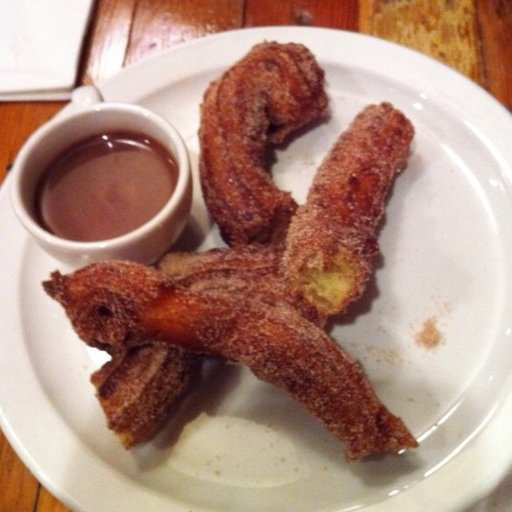

In [5]:
# View first sample (PIL Image format)
print(class_names[train_data[0][1]])
train_data[0][0]

## Find subset of appropriate classes

Want: Steak, pizza, sushi.

Current path setup:

```
../data/food-101/images/CLASS_NAME/IMAGES.jpg
```

Going to get a list of the different target image classes (`pizza`, `steak`, `sushi`) filenames and then copy the images to separate folders.

I'd like to get a random 10% of the images from the target classes from both datasets.

In [6]:
# Get random 10% of training images
import random

# Setup data paths
data_path = data_dir / "food-101" / "images"
target_classes = ["pizza", "steak", "sushi"]

# Change amount of data to get (e.g. 0.1 = random 10%, 0.2 = random 20%)
amount_to_get = 0.2

# Create function to separate a random amount of data
def get_subset(image_path=data_path,
               data_splits=["train", "test"], 
               target_classes=["pizza", "steak", "sushi"],
               amount=0.1,
               seed=42):
    random.seed(42)
    label_splits = {}
    
    # Get labels
    for data_split in data_splits:
        print(f"[INFO] Creating image split for: {data_split}...")
        label_path = data_dir / "food-101" / "meta" / f"{data_split}.txt"
        with open(label_path, "r") as f:
            labels = [line.strip("\n") for line in f.readlines() if line.split("/")[0] in target_classes] 
        
        # Get random subset of target classes image ID's
        number_to_sample = round(amount * len(labels))
        print(f"[INFO] Getting random subset of {number_to_sample} images for {data_split}...")
        sampled_images = random.sample(labels, k=number_to_sample)
        
        # Apply full paths
        image_paths = [pathlib.Path(str(image_path / sample_image) + ".jpg") for sample_image in sampled_images]
        label_splits[data_split] = image_paths
    return label_splits
        
label_splits = get_subset(amount=amount_to_get)
label_splits["train"][:10]

[INFO] Creating image split for: train...
[INFO] Getting random subset of 450 images for train...
[INFO] Creating image split for: test...
[INFO] Getting random subset of 150 images for test...


[PosixPath('../data/food-101/images/pizza/3269634.jpg'),
 PosixPath('../data/food-101/images/pizza/1524655.jpg'),
 PosixPath('../data/food-101/images/steak/2825100.jpg'),
 PosixPath('../data/food-101/images/steak/225990.jpg'),
 PosixPath('../data/food-101/images/steak/1839481.jpg'),
 PosixPath('../data/food-101/images/pizza/38349.jpg'),
 PosixPath('../data/food-101/images/pizza/3018077.jpg'),
 PosixPath('../data/food-101/images/sushi/93139.jpg'),
 PosixPath('../data/food-101/images/pizza/2702825.jpg'),
 PosixPath('../data/food-101/images/sushi/200025.jpg')]

## Move training and testing images to dedicated folders

In [8]:
# Create target directory path
target_dir_name = f"../data/pizza_steak_sushi_{str(int(amount_to_get*100))}_percent"
print(f"Creating directory: '{target_dir_name}'")

# Setup the directories
target_dir = pathlib.Path(target_dir_name)

# Make the directories
target_dir.mkdir(parents=True, exist_ok=True)

Creating directory: '../data/pizza_steak_sushi_20_percent'


In [9]:
import shutil

for image_split in label_splits.keys():
    for image_path in label_splits[str(image_split)]:
        dest_dir = target_dir / image_split / image_path.parent.stem / image_path.name
        if not dest_dir.parent.is_dir():
            dest_dir.parent.mkdir(parents=True, exist_ok=True)
        print(f"[INFO] Copying {image_path} to {dest_dir}...")
        shutil.copy2(image_path, dest_dir)

[INFO] Copying ../data/food-101/images/pizza/3269634.jpg to ../data/pizza_steak_sushi_20_percent/train/pizza/3269634.jpg...
[INFO] Copying ../data/food-101/images/pizza/1524655.jpg to ../data/pizza_steak_sushi_20_percent/train/pizza/1524655.jpg...
[INFO] Copying ../data/food-101/images/steak/2825100.jpg to ../data/pizza_steak_sushi_20_percent/train/steak/2825100.jpg...
[INFO] Copying ../data/food-101/images/steak/225990.jpg to ../data/pizza_steak_sushi_20_percent/train/steak/225990.jpg...
[INFO] Copying ../data/food-101/images/steak/1839481.jpg to ../data/pizza_steak_sushi_20_percent/train/steak/1839481.jpg...
[INFO] Copying ../data/food-101/images/pizza/38349.jpg to ../data/pizza_steak_sushi_20_percent/train/pizza/38349.jpg...
[INFO] Copying ../data/food-101/images/pizza/3018077.jpg to ../data/pizza_steak_sushi_20_percent/train/pizza/3018077.jpg...
[INFO] Copying ../data/food-101/images/sushi/93139.jpg to ../data/pizza_steak_sushi_20_percent/train/sushi/93139.jpg...
[INFO] Copying ../

In [11]:
# Check lengths of directories
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  import os
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
walk_through_dir(target_dir)

There are 2 directories and 0 images in '../data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in '../data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 58 images in '../data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in '../data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 46 images in '../data/pizza_steak_sushi_20_percent/test/pizza'.
There are 3 directories and 0 images in '../data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 146 images in '../data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in '../data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 154 images in '../data/pizza_steak_sushi_20_percent/train/pizza'.


Looks like we've got about ~75 training images per class and ~25 testing images per class (or more if you're using a higher percentage, e.g. ~150 training images per class and ~50 testing images per class for 20% of the data).

This should be enough for a starting dataset.

We can always increased them if needed.

## Zip up images folder to be more easily transported

In [12]:
# Zip pizza_steak_sushi images
zip_file_name = data_dir / f"pizza_steak_sushi_{str(int(amount_to_get*100))}_percent"
shutil.make_archive(zip_file_name, 
                    format="zip", 
                    root_dir=target_dir)

'/home/daniel/code/pytorch/pytorch-course/pytorch-deep-learning/data/pizza_steak_sushi_20_percent.zip'

In [13]:
!ls -la ../data/

total 4978576
drwxrwxr-x  8 daniel daniel       4096 Apr 17 14:24 .
drwxrwxr-x 16 daniel daniel       4096 Apr 16 13:41 ..
-rw-rw-r--  1 daniel daniel    2874848 Apr  4 09:47 04-pizza-dad.jpeg
drwxrwxr-x  4 daniel daniel       4096 Nov  9 15:34 10_whole_foods
-rw-rw-r--  1 daniel daniel   51633879 Nov 25 15:20 10_whole_foods.zip
drwxrwxr-x  3 daniel daniel       4096 Nov  3 11:14 FashionMNIST
drwxr-xr-x  4 daniel daniel       4096 Jul  9  2014 food-101
-rw-rw-r--  1 daniel daniel 4996278331 Mar 25 18:03 food-101.tar.gz
drwxrwxr-x  2 daniel daniel       4096 Apr  4 09:48 .ipynb_checkpoints
drwxrwxr-x  4 daniel daniel       4096 Mar 29 10:23 pizza_steak_sushi
drwxrwxr-x  4 daniel daniel       4096 Apr 17 14:22 pizza_steak_sushi_20_percent
-rw-rw-r--  1 daniel daniel   31491084 Apr 17 14:24 pizza_steak_sushi_20_percent.zip
-rw-rw-r--  1 daniel daniel   15737296 Apr 14 11:58 pizza_steak_sushi.zip


In [15]:
!mkdir -p pizza_steak_sushi
!unzip ../data/pizza_steak_sushi_20_percent.zip -d pizza_steak_sushi

Archive:  ../data/pizza_steak_sushi_20_percent.zip
   creating: pizza_steak_sushi/test/
   creating: pizza_steak_sushi/train/
   creating: pizza_steak_sushi/test/pizza/
   creating: pizza_steak_sushi/test/steak/
   creating: pizza_steak_sushi/test/sushi/
  inflating: pizza_steak_sushi/test/steak/831681.jpg  
  inflating: pizza_steak_sushi/test/steak/3100563.jpg  
  inflating: pizza_steak_sushi/test/steak/2752603.jpg  
  inflating: pizza_steak_sushi/test/steak/39461.jpg  
  inflating: pizza_steak_sushi/test/steak/730464.jpg  
  inflating: pizza_steak_sushi/test/steak/1523026.jpg  
  inflating: pizza_steak_sushi/test/steak/1848936.jpg  
  inflating: pizza_steak_sushi/test/steak/3063435.jpg  
  inflating: pizza_steak_sushi/test/steak/1882831.jpg  
  inflating: pizza_steak_sushi/test/steak/1655387.jpg  
  inflating: pizza_steak_sushi/test/steak/2353677.jpg  
  inflating: pizza_steak_sushi/test/steak/3873655.jpg  
  inflating: pizza_steak_sushi/test/steak/2475366.jpg  
  inflating: pizza_st

In [16]:
!ls ../data

04-pizza-dad.jpeg   food-101.tar.gz
10_whole_foods	    pizza_steak_sushi
10_whole_foods.zip  pizza_steak_sushi_20_percent
FashionMNIST	    pizza_steak_sushi_20_percent.zip
food-101	    pizza_steak_sushi.zip


In [17]:
walk_through_dir("pizza_steak_sushi")

There are 2 directories and 0 images in 'pizza_steak_sushi'.
There are 3 directories and 0 images in 'pizza_steak_sushi/test'.
There are 0 directories and 58 images in 'pizza_steak_sushi/test/steak'.
There are 0 directories and 46 images in 'pizza_steak_sushi/test/sushi'.
There are 0 directories and 46 images in 'pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'pizza_steak_sushi/train'.
There are 0 directories and 146 images in 'pizza_steak_sushi/train/steak'.
There are 0 directories and 150 images in 'pizza_steak_sushi/train/sushi'.
There are 0 directories and 154 images in 'pizza_steak_sushi/train/pizza'.


In [21]:
# # Remove extra data
# import os
# os.remove("pizza_steak_sushi")
# shutil.rmtree("pizza_steak_sushi")

IsADirectoryError: [Errno 21] Is a directory: 'pizza_steak_sushi'

In [22]:
!ls

04_custom_data_creation.ipynb  exercises  resize_images.ipynb  solutions
